**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did an excellent job overall! There's just one small suggestion for improvement: applying oversampling to the whole cross-validation dataset is problematic, but as oversampling is not applied to the test set, at least we're getting correct test set scores :) See the comment below for more information on that. The code is accepted. Based on your best model's ROC-AUC, you've got 6 SP. Congratulations!

# Final Project

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

## Interconnect's services

Interconnect mainly provides two types of services:

1. Landline communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up via a telephone line (DSL, *digital subscriber line*) or through a fiber optic cable.

Some other services the company provides include:

- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

## Data Description

The data consists of files obtained from different sources:

- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.

## Clarification: Summary 
Target feature: the `'EndDate'` column equals `'No'`.

Primary metric: AUC-ROC.

Additional metric: Accuracy.

Assessment criteria:

- AUC-ROC < 0.75 — 0 SP
- 0.75 ≤ AUC-ROC < 0.81 — 4 SP
- 0.81 ≤ AUC-ROC < 0.85 — 4.5 SP
- 0.85 ≤ AUC-ROC < 0.87 — 5 SP
- 0.87 ≤ AUC-ROC < 0.88 — 5.5 SP
- AUC-ROC ≥ 0.88 — 6 SP

## Preprocessing

In [1]:
pip install -U imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: imbalanced-learn in /home/jovyan/.local/lib/python3.7/site-packages (0.8.1)
Note: you may need to restart the kernel to use updated packages.


### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from imblearn.over_sampling import RandomOverSampler
from IPython.display import display
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool

In [3]:
def general_info(path):
    df = pd.read_csv(path)  
    display('Head:', df.head())
    display('Info:')
    display(df.info())
    display('Description:', df.describe())
    display('Missing values:', df.isna().sum())
    display('Duplicates:', df.duplicated().sum())
    return df

### Tables

#### Contract

In [4]:
contract = general_info('/datasets/final_provider/contract.csv')

'Head:'

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


'Info:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

'Description:'

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


'Missing values:'

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

'Duplicates:'

0

**Visible problems:**
* EndDate column has 'No' values instead of generic date.
* Type, PaperlessBilling & PaymentMethod columns have descriptive strings instead of numbers.
* BeginDate & EndDate columns have to be coverted to date type.
* Type & PaperlessBilling columns have to be coverted to binary type.
* PaymentMethod column has to be coverted to category type.
* TotalCharges column has to be coverted to float type.
* MonthlyCharges column has NaN values.
* Most of the values in EndDate column are 'No' values. Because this column is our target column, we can say that the data set is imbalanced.

#### Personal

In [5]:
personal = general_info('/datasets/final_provider/personal.csv')

'Head:'

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


'Info:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

'Description:'

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


'Missing values:'

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

'Duplicates:'

0

**Visible problems:**
* SeniorCitizen column has NaN values.
* gender, Partner & Dependents columns have string values instead of binary values.
* gender, SeniorCitizen, Partner & Dependents columns have to be coverted to binary type.

#### Internet

In [6]:
internet = general_info('/datasets/final_provider/internet.csv')

'Head:'

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


'Info:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


None

'Description:'

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,9620-ENEJV,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


'Missing values:'

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

'Duplicates:'

0

**Visible problems:**
* InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV & StreamingMovies columns have string values instead of binary values.
* InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV & StreamingMovies columns have to be coverted to binary type.

#### Phone

In [7]:
phone = general_info('/datasets/final_provider/phone.csv')

'Head:'

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


'Info:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


None

'Description:'

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,9620-ENEJV,No
freq,1,3390


'Missing values:'

customerID       0
MultipleLines    0
dtype: int64

'Duplicates:'

0

**Visible problems:**
*  MultipleLines column has string values instead of binary values.
*  MultipleLines column has to be coverted to binary type.

### Merging Tables

In [8]:
df1 = contract.merge(personal, how='outer', on='customerID')
df2 = internet.merge(phone, how='outer', on='customerID')
df = df1.merge(df2, how='outer', on='customerID')

#### Merged Table

In [9]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


#### Lowercase columns names

In [10]:
df.columns = df.columns.str.lower()
df.columns

Index(['customerid', 'begindate', 'enddate', 'type', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'gender',
       'seniorcitizen', 'partner', 'dependents', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'multiplelines'],
      dtype='object')

#### Info

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
customerid          7043 non-null object
begindate           7043 non-null object
enddate             7043 non-null object
type                7043 non-null object
paperlessbilling    7043 non-null object
paymentmethod       7043 non-null object
monthlycharges      7043 non-null float64
totalcharges        7043 non-null object
gender              7043 non-null object
seniorcitizen       7043 non-null int64
partner             7043 non-null object
dependents          7043 non-null object
internetservice     5517 non-null object
onlinesecurity      5517 non-null object
onlinebackup        5517 non-null object
deviceprotection    5517 non-null object
techsupport         5517 non-null object
streamingtv         5517 non-null object
streamingmovies     5517 non-null object
multiplelines       6361 non-null object
dtypes: float64(1), int64(1), object(18)
memory usage: 1.1+ MB


#### Descriptive statistics

In [12]:
df.describe(include='all')

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
count,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,5517,5517,5517,5517,5517,5517,5517,6361
unique,7043,77,5,3,2,4,NaN,6531,2,NaN,2,2,2,2,2,2,2,2,2,2
top,9620-ENEJV,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,20.2,Male,NaN,No,No,Fiber optic,No,No,No,No,No,No,No
freq,1,366,5174,3875,4171,2365,NaN,11,3555,NaN,3641,4933,3096,3498,3088,3095,3473,2810,2785,3390
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN,0.162147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN,0.368612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


####  Missing Values

In [13]:
for col in df:
    print('Column: ', col, 
          '\nNumber of values: ', df[col].nunique(dropna=False), 
          '\nUnique values: ', df[col].unique(),
          '\n' + '_'*50
         )
    

Column:  customerid 
Number of values:  7043 
Unique values:  ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'] 
__________________________________________________
Column:  begindate 
Number of values:  77 
Unique values:  ['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2

In [14]:
df.enddate.replace({'No': '2020-02-01'}, inplace=True)
df.totalcharges.replace({' ': 0}, inplace=True)
df.replace({np.NaN:'No'}, inplace=True)

#### Duplicates

In [15]:
df.customerid.duplicated().sum()

0

#### Converting Data Types

In [16]:
df['begindate'] = pd.to_datetime(df['begindate'], format='%Y-%m-%d')
df['enddate'] = pd.to_datetime(df['enddate'], format='%Y-%m-%d')
df.totalcharges = df.totalcharges.astype('float64')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
customerid          7043 non-null object
begindate           7043 non-null datetime64[ns]
enddate             7043 non-null datetime64[ns]
type                7043 non-null object
paperlessbilling    7043 non-null object
paymentmethod       7043 non-null object
monthlycharges      7043 non-null float64
totalcharges        7043 non-null float64
gender              7043 non-null object
seniorcitizen       7043 non-null int64
partner             7043 non-null object
dependents          7043 non-null object
internetservice     7043 non-null object
onlinesecurity      7043 non-null object
onlinebackup        7043 non-null object
deviceprotection    7043 non-null object
techsupport         7043 non-null object
streamingtv         7043 non-null object
streamingmovies     7043 non-null object
multiplelines       7043 non-null object
dtypes: datetime64[ns](2), float64(2), int64(1), object(

#### Adding Features

In [18]:
df['duration'] = ((df.enddate - df.begindate)/np.timedelta64(1, 'D'))
df['duration'] = df['duration'].astype(int)


def isClient(row):
    if row.enddate == datetime.datetime(2020, 2, 1):
        return 1
    else:
        return 0

df['isclient'] = df.apply(isClient, axis=1)
df.sample(20)  

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,...,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,duration,isclient
1046,0810-DHDBD,2015-10-01,2020-02-01,One year,No,Credit card (automatic),74.00,3877.65,Female,0,...,DSL,Yes,No,Yes,Yes,Yes,No,Yes,1584,1
1598,7552-KEYGT,2017-11-01,2020-02-01,Two year,No,Bank transfer (automatic),19.55,520.55,Male,0,...,No,No,No,No,No,No,No,No,822,1
2943,4526-EXKKN,2016-10-01,2020-02-01,Two year,Yes,Mailed check,24.60,973.95,Male,0,...,No,No,No,No,No,No,No,Yes,1218,1
5403,0292-WEGCH,2015-08-01,2020-02-01,Month-to-month,Yes,Electronic check,86.20,4524.05,Female,0,...,DSL,No,Yes,Yes,Yes,Yes,Yes,Yes,1645,1
5971,9800-OUIGR,2014-08-01,2020-02-01,Two year,No,Credit card (automatic),20.00,1374.20,Male,0,...,No,No,No,No,No,No,No,No,2010,1
4255,2157-MXBJS,2018-10-01,2019-11-01,One year,Yes,Mailed check,75.30,989.45,Male,0,...,DSL,No,No,Yes,No,Yes,Yes,Yes,396,0
6593,4701-AHWMW,2015-05-01,2019-12-01,Month-to-month,Yes,Bank transfer (automatic),54.55,2978.30,Male,0,...,DSL,No,No,Yes,Yes,Yes,Yes,No,1675,0
2591,8384-FZBJK,2015-05-01,2020-02-01,Month-to-month,Yes,Electronic check,100.60,5611.70,Female,0,...,Fiber optic,No,Yes,No,No,Yes,Yes,Yes,1737,1
2979,8996-ZROXE,2015-05-01,2020-02-01,One year,Yes,Electronic check,53.50,3035.80,Male,1,...,DSL,No,No,Yes,Yes,No,No,No,1737,1
539,5394-MEITZ,2015-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),80.60,4946.70,Female,0,...,DSL,No,Yes,Yes,Yes,Yes,Yes,No,1826,1


#### Dropping unnecessary columns

In [19]:
df.drop(['customerid', 'begindate', 'enddate'], axis=1, inplace=True)
df.columns

Index(['type', 'paperlessbilling', 'paymentmethod', 'monthlycharges',
       'totalcharges', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines',
       'duration', 'isclient'],
      dtype='object')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
type                7043 non-null object
paperlessbilling    7043 non-null object
paymentmethod       7043 non-null object
monthlycharges      7043 non-null float64
totalcharges        7043 non-null float64
gender              7043 non-null object
seniorcitizen       7043 non-null int64
partner             7043 non-null object
dependents          7043 non-null object
internetservice     7043 non-null object
onlinesecurity      7043 non-null object
onlinebackup        7043 non-null object
deviceprotection    7043 non-null object
techsupport         7043 non-null object
streamingtv         7043 non-null object
streamingmovies     7043 non-null object
multiplelines       7043 non-null object
duration            7043 non-null int64
isclient            7043 non-null int64
dtypes: float64(2), int64(3), object(14)
memory usage: 1.1+ MB


### Conclusion
In this section, we:
* had a first look on the data
* merged tables
* replaced some wrong values
* added duration and isclient features
* dropped unnecessary columns
* checked for duplicates
* converted to appropriate data types

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you preprocessed the data, correctly merged the dataframes (so the data on clients who don't use both phone and internet is not lost) and added a good feature (contract duration). Both begindate and enddate were dropped, so there should be no target leakage

</div>

## EDA

### Plotting Distributions

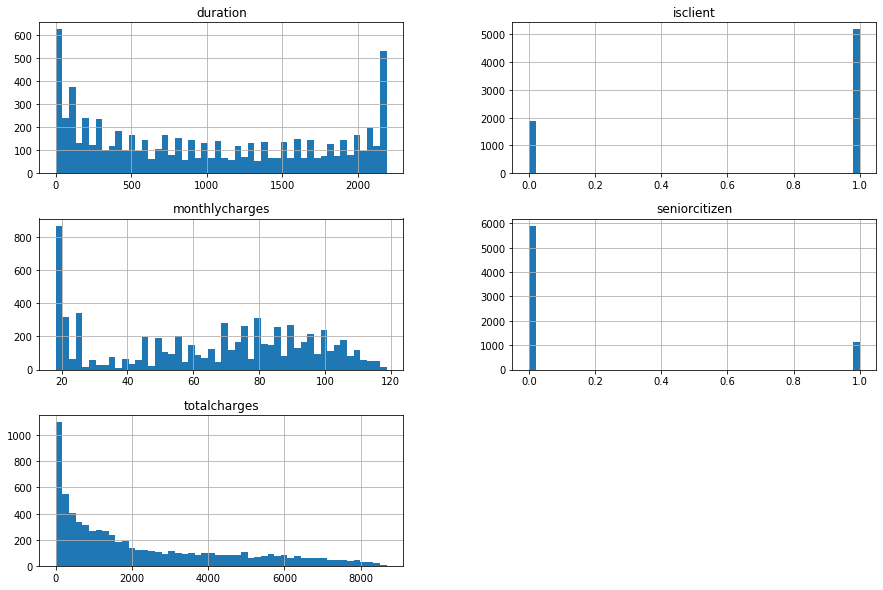

In [21]:
df.hist(xrot=None, yrot=None, figsize=(15, 10),  bins=50)
plt.show()

We can see that our distibutions aren't normal and the data isn't balanced.

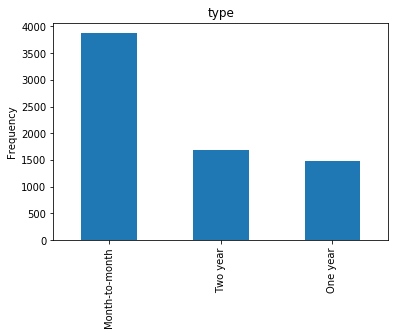

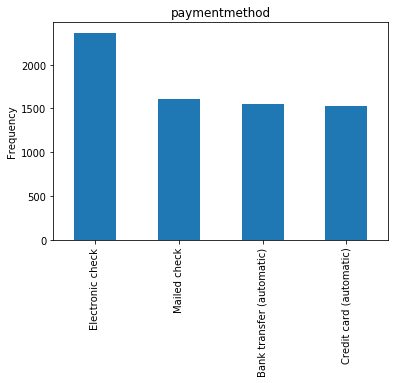

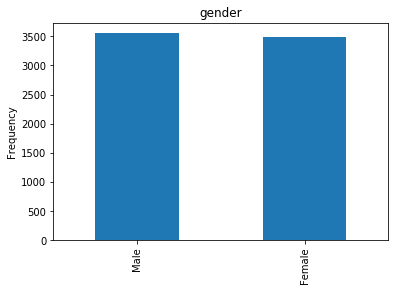

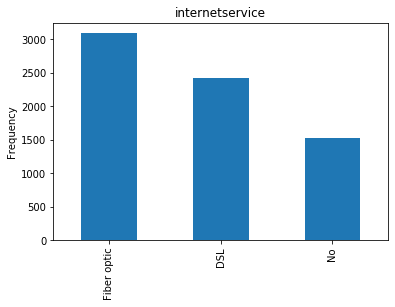

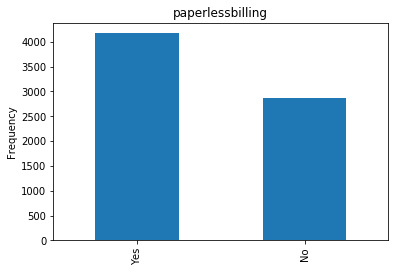

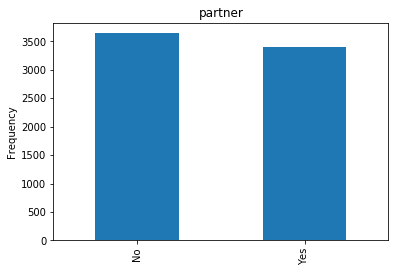

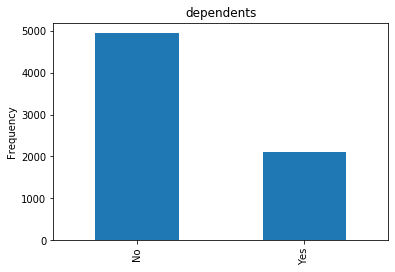

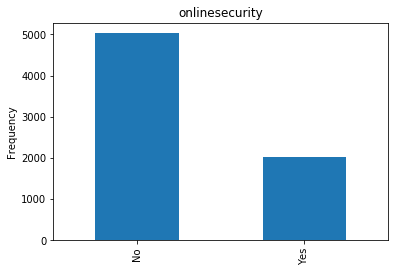

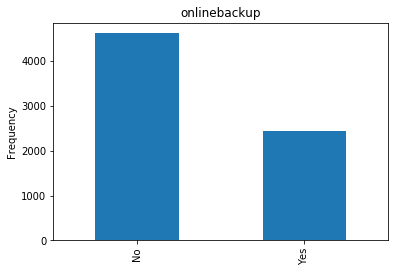

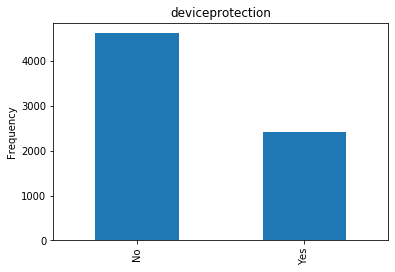

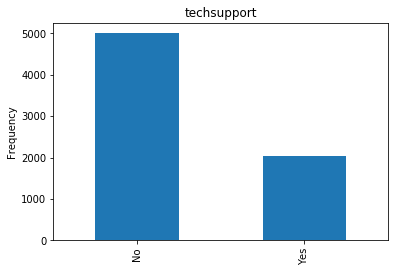

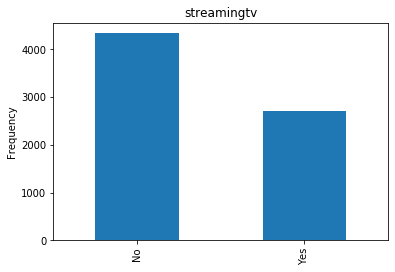

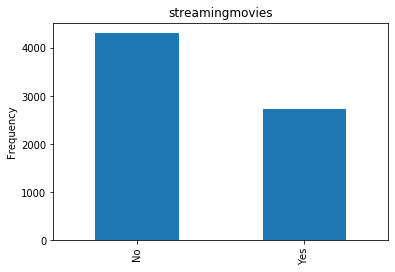

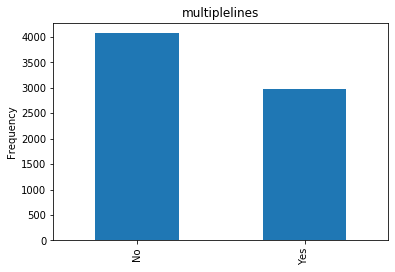

In [22]:
cols = ['type', 'paymentmethod', 'gender', 'internetservice', 'paperlessbilling', 'partner', 'dependents', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']
for col in cols:
    display(df[col].value_counts().plot.bar())
    plt.title(col)
    plt.ylabel('Frequency')
    plt.show()

We can see the above the differences between the categorical columns.

### Correlations Hot Map

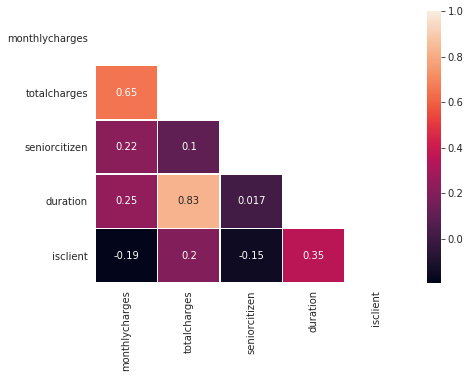

In [23]:
corr = df.corr()

mask = np.zeros_like(corr)

mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(7, 5))

    ax = sns.heatmap(corr, linewidths=.5, annot=True, mask=mask)


We can see above the features' correlations. The highest correlation is 0.83 (duration & totalcharges).

<div class="alert alert-success">
<b>Reviewer's comment</b>

Nice EDA!

</div>

## Training & Testing

### One-Hot-Encoding

In [24]:
data_ohe = pd.get_dummies(df, drop_first=True)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Categorical features were encoded correctly

</div>

### Features & Target Split

In [25]:
target = data_ohe['isclient']
features = data_ohe.drop('isclient', axis=1)

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)


<div class="alert alert-success">
<b>Reviewer's comment</b>

Target variable fits the task. The data is split into train and test sets, the proportion is reasonable

</div>

### Class Imbalance

In [26]:
target.value_counts(normalize=True)

1    0.73463
0    0.26537
Name: isclient, dtype: float64

Our target isn't balanced.

### Resampling

In [27]:
ros = RandomOverSampler(random_state=0)

features_resampled, target_resampled = ros.fit_resample(features_train, target_train)

In [28]:
target_resampled.value_counts(normalize=True)


1    0.5
0    0.5
Name: isclient, dtype: float64

<div class="alert alert-warning">
<b>Reviewer's comment</b>

It's nice that you're appling oversampling to deal with class imbalance, but note that you might be getting suboptimal models through the hyperparameter tuning process with cross-validation, because if we apply oversampling to the whole dataset used for cross-validation, there may be data leakage in all cross-validation folds (i.e. there may be examples appearing in both train and validation subsets of the fold). The easiest way to fix this is using [imblearn pipelines](https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.Pipeline.html#imblearn.pipeline.Pipeline): just add your oversampler and a model in a pipeline and pass it to `GridSearchCV` instead of a model. Now in each cross-validation fold oversampling will be applied only to the fold's train subset, which fixed the problem I described above.

</div>

### Dummy Classifier

In [29]:
dc = DummyClassifier(strategy="stratified", random_state=1)
dc.fit(features_train, target_train)
preds = dc.predict_proba(features_test)[:, 1]
print('Dummy classifier ROC-AUc score: {:.3f}'.format(roc_auc_score(target_test, preds)))
print('Dummy classifier accuracy score: {:.3f}'.format(accuracy_score(target_test, preds)))

Dummy classifier ROC-AUc score: 0.509
Dummy classifier accuracy score: 0.610


Our baseline model doesn't do great job.

<div class="alert alert-success">
<b>Reviewer's comment</b>

There's a baseline, good!
    
</div>

### Logistic Regression

In [30]:
steps = [('scaler', StandardScaler()), ('lr', LogisticRegression(solver='liblinear', class_weight='balanced', random_state = 12345))]
pipe = Pipeline(steps)

param_grid={
     'lr__penalty':['l1', 'l2', 'elasticnet', 'none']
 }

gscv = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv=5)

gscv.fit(features_train, target_train)
preds = gscv.predict_proba(features_test)[:, 1]
accu_preds = gscv.predict(features_test)

print("Logistic Regression best AUC-ROC score: {:.3f}".format(gscv.best_score_))
print(gscv.best_params_)
print('Logistic Regression accuracy score: {:.3f}'.format(accuracy_score(accu_preds, target_test)))

Logistic Regression best AUC-ROC score: 0.847
{'lr__penalty': 'l2'}
Logistic Regression accuracy score: 0.742


Our Logistic Regression' scores are better than the baseline model.

### Random Forest Classifier

In [31]:
steps = [('scaler', StandardScaler()), ('rfc', RandomForestClassifier(random_state=12345, class_weight='balanced'))]

pipe = Pipeline(steps)

param_grid = {
    'rfc__n_estimators': [10, 30, 50, 100, 200]
}

gscv = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv=5)

gscv.fit(features_train, target_train)
preds = gscv.predict_proba(features_test)[:, 1]
accu_preds = gscv.predict(features_test)

print("Random Forest best AUC-ROC score: {:.3f}".format(gscv.best_score_))
print(gscv.best_params_)
print('Random Forest accuracy score: {:.3f}'.format(accuracy_score(accu_preds, target_test)))

Random Forest best AUC-ROC score: 0.844
{'rfc__n_estimators': 200}
Random Forest accuracy score: 0.806


The random forest model AUC-ROC score is very close to the Logistic Regression, but the accuracy is higher.

### CatBoost Classifier

In [32]:
cbc = CatBoostClassifier(random_seed=12345)

param_distribution = {
    'learning_rate': [0.03, 0.1, 0.2], 
    'iterations':[100, 200, 300]
}

randomized_search_results = cbc.randomized_search(
    param_distribution,
    features_resampled, 
    target_resampled
)

0:	loss: 0.4306784	best: 0.4306784 (0)	total: 3.24s	remaining: 25.9s
1:	loss: 0.3822274	best: 0.3822274 (1)	total: 5.29s	remaining: 18.5s
2:	loss: 0.3255040	best: 0.3255040 (2)	total: 7.5s	remaining: 15s
3:	loss: 0.4051596	best: 0.3255040 (2)	total: 12s	remaining: 15s
4:	loss: 0.3143113	best: 0.3143113 (4)	total: 16.7s	remaining: 13.4s
5:	loss: 0.2696945	best: 0.2696945 (5)	total: 21.6s	remaining: 10.8s
6:	loss: 0.3836411	best: 0.2696945 (5)	total: 28.2s	remaining: 8.06s
7:	loss: 0.2764309	best: 0.2696945 (5)	total: 34.8s	remaining: 4.35s
8:	loss: 0.2320716	best: 0.2320716 (8)	total: 41.3s	remaining: 0us
Estimating final quality...


In [33]:
preds = cbc.predict_proba(features_test)[:,1]
accu_preds = cbc.predict(features_test)

print("CatBoost best AUC-ROC score: {:.3f}".format(roc_auc_score(target_test, preds)))
print('CatBoost accuracy score: {:.3f}'.format(accuracy_score(accu_preds, target_test)))

CatBoost best AUC-ROC score: 0.902
CatBoost accuracy score: 0.844


The CatBoost model has the best scores.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you tried a couple of different models and tuned their hyperparameters using a cross-validated grid search. The final models were evaluated on the test set. 

</div>

## General Conclusion
Our assignment was to predict the churn rate of Interconnect's clientele. 

In the first step, we preprocessed the dataset:
* Merging the tables to one table.
* Replacing some values and filling in missing values.
* Converting data types to the appropriate ones.
* Adding two features.
* Dropping unnecessary columns.
* Checking for customerid duplicates.
* Checking the unique values of each column.

In the second step, we plotted several visualizations in order to have a better understanding of our data. We could see that our data isn't balanced, both target and features. In addition, we checked the correlation between features.

In the next step, we prepared the data for training. Because we had alot of categorical features, we had to encode the data using the One-Hot -Encoding method. We also resampled the data, dealing with the imbalanced label.

Finally, we tried some models:
* A baseline model, which was Dummy Classifier.
* Logistic Regression
* Random Forest Classifier
* CatBoost Classifier.

In comparison with the other models, the CatBoost Classifier model had the best results.